In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform

In [2]:
format_plots()
#format_pizza_plots()

In [3]:
## update data
def filter_df(df):
    max=100
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [6]:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
m_data = data.query('age < 95').copy()

#m_data = data.copy()

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)
# arrange data
data_labels = df.index.get_level_values('age').to_numpy()
data = df.astype(float, errors='ignore')
data= filter_df(data)
f_data = data.query('age < 95').copy()
#f_data = data.copy()

In [7]:
# arrange data
m_data = m_data.groupby(['age','uuid']).mean()
f_data = f_data.groupby(['age','uuid']).mean()

In [8]:
# calculate distance for chronological age and pseudo age
# for age
bins=[]
kld_males=[]
u_males=[]
c_males=[]
exp=[]
for age,_df in enumerate(m_data.groupby('age')):
    bins.extend(_df[1].index.get_level_values('age').to_numpy())
    exp.extend(['m']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = squareform(pdist(data_temp, metric='jensenshannon'))
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_males.extend(np.mean(kld_temp, axis=1))
    u_males.extend(np.mean(utemp, axis=1))
    c_males.extend(np.mean(ctemp, axis=1))

In [9]:
# calculate distance for chronological age and pseudo age
# for age
# calculate distance for chronological age and pseudo age
# for age
kld_females=[]
u_females=[]
c_females=[]
for age,_df in enumerate(f_data.groupby('age')):
    bins.extend(_df[1].index.get_level_values('age').to_numpy())
    exp.extend(['f']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = squareform(pdist(data_temp, metric='jensenshannon'))
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_females.extend(np.mean(kld_temp, axis=1))
    u_females.extend(np.mean(utemp, axis=1))
    c_females.extend(np.mean(ctemp, axis=1))

In [10]:
# create dataframe for plotting
df=pd.DataFrame()
df['age']=bins
df['jsd']=np.append(kld_males,kld_females)
df['sex']=exp
df['euc']=np.append(u_males,u_females)
df['cosine']=np.append(c_males,c_females)

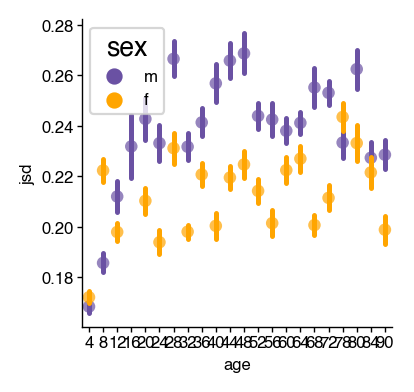

In [11]:
## show mean
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.pointplot(data=df, x="age", 
              y="jsd",
              estimator='mean', 
              errorbar='se', 
              hue = 'sex', 
              palette=['#6a51a3','orange'],
              join=False)
plt.setp(ax.collections, alpha=.7)
plt.setp(ax.collections, edgecolor='none')
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_intra_age_distance_oint.pdf', bbox_inches='tight')

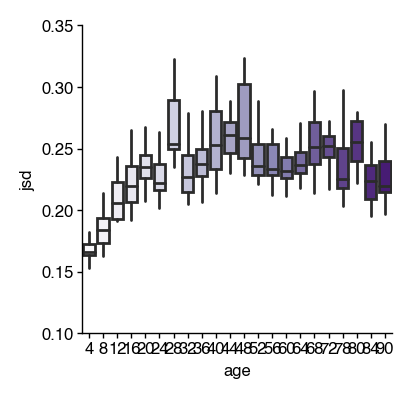

In [12]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df.query("sex == 'm'"), x="age", y="jsd",
             palette = 'Purples', dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.1,0.35)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_intra_age_distance_male.pdf', bbox_inches='tight')

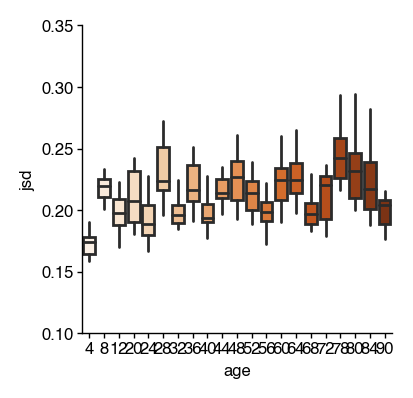

In [13]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df.query("sex == 'f'"), x="age", y="jsd",
             palette = 'Oranges', dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.1,0.35)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_intra_age_distance_female.pdf', bbox_inches='tight')

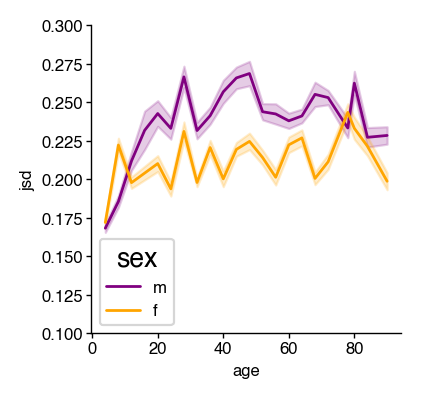

In [14]:
## show means line
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.lineplot(data=df, x="age", y="jsd", hue='sex', 
            #notch= True,
            estimator='mean',
            errorbar = 'se',
            palette = ['purple','orange'], 
            #dodge=True,
            #alpha=0.5,
            #join=False,
            )
ax.set_ylim(0.10,0.3)
sns.despine()

c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'fvm_intra_age_distance_line.pdf', bbox_inches='tight')